In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
from scipy.special import expit as logistic

In [73]:
d = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/chimpanzees.csv", sep = ";")
# create treatment variable
d["treatment"] = d["prosoc_left"] + 2* d["condition"] # needs to startat 0 for pm to work

#actor needs to start at 0 for pm to work
d["actor"] = d["actor"] - 1

In [74]:
d.groupby("treatment")[["prosoc_left", "condition"]].mean()

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


Model 11_1:


$L_i \sim Binomial(1, p_i)$

$logit(p_i) = \alpha$

$\alpha \sim Normal(0, 10)$

In [31]:
m11_1 = pm.Model()
with m11_1:
    a = pm.Normal("a", 0, 10)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_1_prior = pm.sample_prior_predictive()

In [42]:
m11_1b = pm.Model()
with m11_1b:
    a = pm.Normal("a", 0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_1b_prior = pm.sample_prior_predictive()

Model 11_2:


$L_i \sim Binomial(1, p_i)$

$logit(p_i) = \alpha + \beta_{treatment}$

$\alpha \sim Normal(0, 10)$

In [51]:
with pm.Model() as m11_2:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 10, shape = 4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_2_prior = pm.sample_prior_predictive()

In [52]:
with pm.Model() as m11_2b:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 1.5, shape = 4)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_2b_prior = pm.sample_prior_predictive()

In [69]:
# extract alphas
a1 = m11_1_prior["p"]
a2 = m11_1b_prior["p"]

#extract difference between treatment 1 and treatment 2
b1_treat_1, b1_treat_2 = (
    logistic(m11_2_prior["a"] + m11_2_prior["b"][:,0]),
    logistic(m11_2_prior["a"] + m11_2_prior["b"][:,1]))
b2_treat_1, b2_treat_2 = (
    logistic(m11_2b_prior["a"] + m11_2b_prior["b"][:,0]),
    logistic(m11_2b_prior["a"] + m11_2b_prior["b"][:,1]))

b1 = np.abs(b1_treat_1 - b1_treat_2)
b2 = np.abs(b2_treat_1 - b2_treat_2)

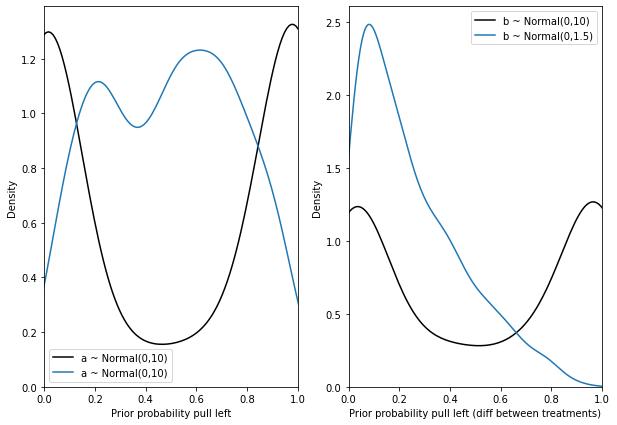

In [71]:
fig, ax = plt.subplots(1,2, figsize = (10,7))
#plot alpha
ax[0].set_xlim(0,1)
sns.kdeplot(a1, ax = ax[0], color = "black", label = "a ~ Normal(0,10)")
sns.kdeplot(a2, ax = ax[0], label = "a ~ Normal(0,10)")
ax[0].set_xlabel("Prior probability pull left")
ax[0].legend()
#plot beta
ax[1].set_xlim(0,1)
sns.kdeplot(b1, ax = ax[1], color = "black", label = "b ~ Normal(0,10)")
sns.kdeplot(b2, ax = ax[1], label = "b ~ Normal(0,1.5)")
ax[1].set_xlabel("Prior probability pull left (diff between treatments)")
ax[1].legend()

plt.show()

In [78]:
with pm.Model() as m11_4:
    a = pm.Normal("a", 0, 1.5, shape = d.actor.nunique())
    b = pm.Normal("b", 0, 1.5, shape = d.treatment.nunique())
    p = pm.Deterministic("p", pm.math.invlogit(a[d.actor] + b[d.treatment]))
    L = pm.Binomial("L", 1, p, observed = d.pulled_left)
    m11_4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [81]:
az.summary(m11_4_trace, var_names = ["a", "b"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.783,0.529,-1.742,0.225,0.018,0.013,895.0,891.0,898.0,1406.0,1.00
a[1],3.673,0.845,2.104,5.247,0.022,0.016,1514.0,1477.0,1533.0,2022.0,1.00
a[2],-1.077,0.533,-2.081,-0.100,0.018,0.013,901.0,901.0,902.0,1434.0,1.00
a[3],-1.086,0.527,-2.060,-0.093,0.018,0.012,904.0,893.0,907.0,1210.0,1.01
a[4],-0.781,0.527,-1.762,0.189,0.018,0.013,882.0,868.0,884.0,1241.0,1.01
a[5],0.158,0.524,-0.840,1.085,0.018,0.013,868.0,868.0,870.0,1405.0,1.00
a[6],1.662,0.580,0.560,2.737,0.018,0.013,997.0,997.0,998.0,1599.0,1.00
b[0],0.275,0.510,-0.714,1.176,0.018,0.012,847.0,847.0,848.0,1065.0,1.00
b[1],0.878,0.508,-0.045,1.866,0.018,0.013,816.0,816.0,817.0,1201.0,1.01
b[2],-0.127,0.511,-1.155,0.757,0.018,0.013,821.0,821.0,823.0,1141.0,1.01


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

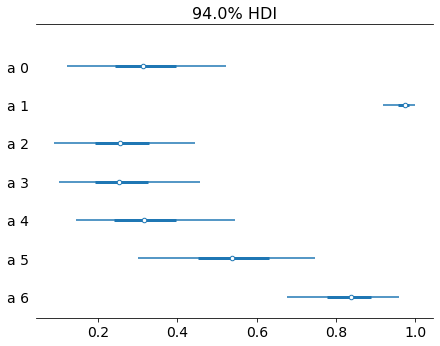

In [87]:
az.plot_forest(m11_4_trace, var_names = "a", transform = logistic, combined = True)

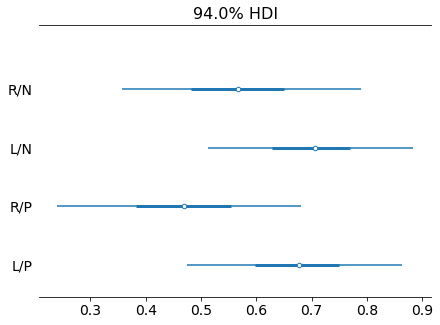

In [93]:
ax = az.plot_forest(m11_4_trace, var_names = "b", transform = logistic, combined = True)
ax[0].set_yticklabels(["L/P", "R/P","L/N", "R/N"])
plt.show()

[Text(0, 0.0, 'db24'), Text(0, 2.25, 'db13')]

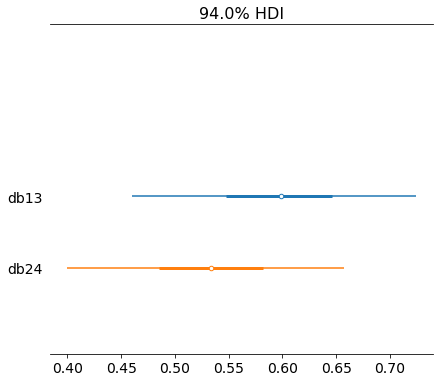

In [99]:
db13 = m11_4_trace["b"][:,0] - m11_4_trace["b"][:,2]
db24 = m11_4_trace["b"][:,1] - m11_4_trace["b"][:,3]
ax = az.plot_forest([db13, db24], transform = logistic, combined = True) #using responsescale so 50% means no difference
ax[0].set_yticklabels(["db24", "db13"])